Before you submit this assignment, make sure everything runs as you expect it to.  
* **restart the kernel** (in the menubar, select Kernel -> Restart)
* **run all cells** (in the menubar, select Cell -> Run All)

Make sure to fill in any place that says 
```python
# YOUR CODE HERE
```
and fill in your name (and of your fellow students, if you submit together), and according matriculation number below. If you are more than one student, separate by a comma **,**

In [1]:
NAME = "Kittiphon Boonma"
MATNUM = "352210"

# Assignment 2: Finite Difference models
##### (30 Points)

After the introduction to scientific computing with Python in the exercise - and the fundamentals of fluid mechanics and porous media flow in the lecture - we are now ready to bring those two things closer together to get closer to solving actual reservoir engineering problems with numerical methods! 

During this exercise, we will first have a look at several methods to solve the types of algebraic systems that we obtain for 1-D Laplace and Poisson equations. Starting from the matrix we developed at the end of the last exercise, we will move from direct solvers to iterative solvers. Finally, we will have a look at the implementation of different boundary conditions and sources and sinks.

If you follow these examples carefully and implement the code correctly for the 1-D example that we consider here, then you are well prepared for the assignment!


In [2]:
# use this cell to import further needed libraries. 
#But generally, these should suffice.

import numpy as np
import math as mt
import matplotlib.pyplot as plt
%matplotlib inline


import colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)


from IPython.core.display import HTML
css_file = 'nre2_style.css'
HTML(open(css_file,'r').read())

## Solving the tridiagonal matrix
##### (10 Points)

During the last lecture, you have seen the meaning of the tridiagonal matrix that we developed at the end of the last exercise: the matrix can be used to solve a problem that can be described with the Laplace equation in 1-D (for Dirichlet boundary conditions).

Here the matrix as a reminder:

$A = \begin{bmatrix}
-2 & 1 & 0 & 0 & \cdots & 0\\
1 & -2 & 1 &  0 & \cdots & 0\\
0 & 1 & -2 & 1 & \cdots & 0\\
\vdots & & & & & \vdots \\
0 & \cdots & 0 & 1 & -2 & 1 \\
0 & \cdots & 0 & 0 & 1 & -2
\end{bmatrix}$

And the system of algebraic equations that we want to solve:

$$A u = b$$ 

where $u$ is the vector with the (unknown) state variables that we want to know, and $b$ encapsulates the boundary conditions.

The straight-forward way to solve this equation is to use the inverted matrix $A^{-1}$. 

**Exercise**:

* write function to create the tridiagonal matrix **(2 Points)**
```python
def tridiag_121(n):
    """
    Create a tridiagonal matrix of 1 -2 1 form of size n x n 
    """
```
* extend it to solve the following problem:  **(3 Points)**  
solve for temperatures (in a steady-state temperature field without sources and sinks) on 10 nodes, considering $b$ with values of of $T_0 = 10^o$C and $T_1 = 20^o$C (These are Dirichlet boundary conditions, which we will get to know later)
```python
def inv_tridiag_121_b(n,b0,b1):
    """
    Make a matrix inversion of a tridiagonal matrix of size 
    n x n with the boundary conditions b (array of size n)
    returns the array u
    """
```

In [3]:
n = 10
dx = n
b0 = 10.
b1 = 20.
max_iter = 10000
epsilon_tol = 1e-6

In [4]:
def tridiag_121(n):
    """
    Create a tridiagonal matrix of 1 -2 1 form of size n x n
    """
    # YOUR CODE HERE
    A = np.zeros(shape=(n,n))
    i,j = np.indices(A.shape)
    A[i==j] = -2.
    A[i==j-1] = 1.
    A[i==j+1] = 1.
    return  A

In [5]:
from numpy.testing import assert_array_equal
assert_array_equal(tridiag_121(10)[7],[ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.])

In [6]:
def inv_tridiag_121_b(n,b0,b1):
    """
    Make a matrix inversion of a tridiagonal matrix of size n x n with the 
    boundary conditions b (also of size n x n)
    """
    # YOUR CODE HERE
    A = tridiag_121(n)
    b = np.zeros(n)
    b[0] = -b0
    b[-1] =-b1
    return np.dot(np.linalg.inv(A), b)

In [7]:
from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(inv_tridiag_121_b(10,10.,20.),[ 10.90909091,  11.81818182,  12.72727273,  13.63636364,
        14.54545455,  15.45454545,  16.36363636,  17.27272727,
        18.18181818,  19.09090909])

Now, create a plot of the results: What do you observe? **(Plot: 3 Points, Text answer: 2 Points)**

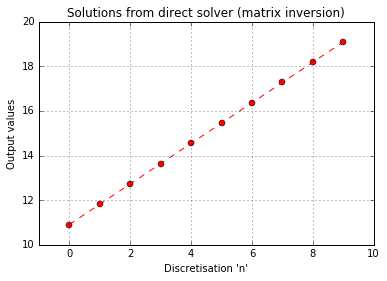

In [8]:
# YOUR CODE HERE
plt.plot(inv_tridiag_121_b(10,10.,20.),'ro--')
plt.xlim([-1,10])
plt.title('Solutions from direct solver (matrix inversion)')
plt.xlabel("Discretisation 'n'")
plt.ylabel("Output values")
plt.grid()

The plot show a linear trend. This linear interpolation is similar to the characteristic arose from physical problems such as Diffusion Problem where we have two heat sources of different temperatures on each of the two sides of a block --> Laplace del^2 T = 0 --> meaning that the edge values take on the values of boundary conditions.


We have seen the previous example before and discussed it in the solution notebook to the last exercise. We will now have a look at other ways to solve the equation.

## Iterative solvers

We didn't discuss iterative methods in the lecture yet (you'll have to wait until next Monday for that), but the basic idea is pretty simple: instead of solving the system of equations at once (as with direct solvers), we start with an initial guess of the solution and then use the algebraic equations to iteratively refine our guess until we reach a solution that is close to the true result.

So, let's first go back one step from the matrix equation above and look again at the underlying equations. We will start with the discretisation of a 1-D Poisson equation (more on this equation as well in the next lecture!) into a central finite difference scheme, considering constant $\Delta x$.

The partial differential equation is:

$$\frac{d^2 u}{d x^2} = q$$

And the central difference discretisation:

$$\frac{u_{i-1} - 2 u_i + u_{i+1}}{\Delta x^2} = q_i$$

We can solve the discrete equation for $u_i$:

$$u_i = \frac{1}{2} \left( u_{i-1} + u_{i+1} - \Delta x^2 q_i\right)$$

If we now consider iterative solution methods, then we basically want to use this expression to obtain a new estimate for $u$ at a time $n+1$ from the values at the previous iteration step $n$. There are two standard ways of doing this that we are now implementing in this exercise.

In addition to defining the iteration methods to solve the problem, we need a way to determine if we converge towards a solution. As we discussed during the lecture, in a general numerical modelling context, we can not actually determine the true convergence because we do not know the true answer. So, what we usually do instead is to check if the solutions do not change anymore from iteration to iteration. This check can be performed in several ways (see lecture). We will here use the L2-norm for convergence, calculated as:

$$\epsilon = \sqrt{\sum_{i,j} \left(u_{i,j}^{n+1} - u_{i,j}^n \right)^2}$$

We stop the iterations when we reach a certain tolerance level so that

$$\epsilon < \epsilon_{tol}$$


## The Jacobi method
##### (10 Points)

The straight-forward way to solve for $u_i$ at a new iteration step is to use the values from the previous iteration, i.e.:

$$u_i^{n+1} = \frac{1}{2} \left( u_{i-1}^n + u_{i+1}^n - \Delta x^2 q_i\right)$$

This method is called the Jacobi method.

**Exercise**: solve the 1-D Laplace problem of before (note: no sources/sinks, so $q$ = 0!) with the Jacobi method with the following steps:

- Write a function for a single iteration **(2 Points)**  
```python
    def jacobi_iter(u,q,dx):
```
- Write a function to update a value $u_i$ **(3 Points)**

These steps will take some work, so here the base construct that you could use:
```python
def solve_laplace_jac(b0,b1,dx,max_iter,epsilon_tol):
    # initialize u with all ones
    u = 
    # Set boundary conditions b0 and b1 at beginning and end of u
    # set parameters
    # no sources / sinks, so set q to 0
    # do a for loop for jacobi iterations
        # copy results from previous iteration
        # perform iteration
        # check for convergence by calculating epsilon
        # if epsilon is smaller than epsilon_tol, break for loop
    return u,i # i being the current iteration
```
- Apply this function __solve_laplace_jac__ iteratively until a convergence criteria is met
- The function should return u and the current iteration i_jac:
    - *u,i_jac = solve_laplace_jac(b0,b1,dx,max_iter,epsilon_tol)*
- Plot the results **(3 Points)**
- Compare them to the direct solution **(2 Points)**

In [9]:
# First step: define the function for a single iteration:

def jacobi_iter(u, q, dx):
    """Function to perform the Jacobi iteration for all values in the array u
    
    u = 1-D np.array with values of previous iteration
    q = 1-D np.array with source/sink terms (not required for Laplace solution!)
    dx = float : node spacing (not required for Laplace solution!)
    """   
    # Hint: do not forget to create a copy of u before you overwrite the values!!
    
    # YOUR CODE HERE
    u_iter=u.copy()
    for i in range(1,dx-1):
        u[i] = 0.5 * (u_iter[i-1] + u_iter[i+1] - (dx**2 * q[i]))
    return u

In [10]:
def solve_laplace_jac(b0,b1,dx,max_iter,epsilon_tol):
    """
    Function to solve the 1D problem in iterations until 
    convergence is met
    Initialize u within this function!
    b0 = boundary condition 1
    b1 = boundaray condition 2
    dx = discretization (= n)
    max_iter = maximum iteration number
    epsilon_tol = convergence limit
    """
    
    # YOUR CODE HERE
    # initialize u with all ones
    u = np.ones(dx)
    
    # Set boundary conditions b0 and b1 at beginning and end of u
    u[0] = b0
    u[-1] = b1
    
    # set parameters
    
   
    # no sources / sinks, so set q to 0
    q = np.zeros(dx)
    
        
    # do a for loop for jacobi iterations
    for iter in range(max_iter):

        # copy results from previous iteration
        u_previous = u.copy()
                  
        # perform iteration
        u_current = jacobi_iter(u, q, dx)
        u = u_current
               
        # check for convergence by calculating epsilon
        epsilon = np.sqrt(np.sum((u - u_previous)**2))
                      
        # if epsilon is smaller than epsilon_tol, break for loop
        if epsilon < epsilon_tol:
            break
        
    return u, iter

####################################################################

solve_laplace_jac(30.,50.,10,10000,1e-6)

(array([ 30.        ,  32.22221993,  34.44444006,  36.66666086,
         38.88888218,  41.11110451,  43.33332743,  45.55555125,
         47.77777545,  50.        ]), 253)

In [11]:
assert_array_almost_equal(solve_laplace_jac(30.,50.,10,10000,1e-6)[0],[ 30.,32.22221993,34.44444006,36.66666086,
                                                                        38.88888218, 41.11110451,  43.33332743,
                                                                        45.55555125, 47.77777545,  50.])

Now: create a plot and compare the result for the direct solution you obtained before:
*Note* Your function should return two parameters, $u\_jac$ and the current iteration $iter\_jac$, so be called:
```python
u_jac,iter_jac = solve_laplace_jac(b0,b1,dx,max_iter,epsilon_tol)
```

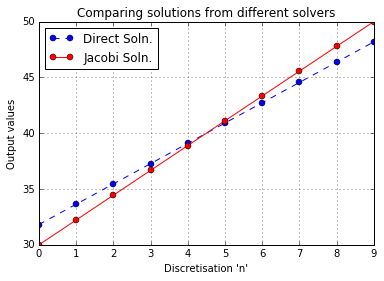

In [12]:
# YOUR CODE HERE
n = 10
dx = n
b0 = 30.
b1 = 50.
max_iter = 10000
epsilon_tol = 1e-6

#Direct Solution
direct = plt.plot(inv_tridiag_121_b(n,b0,b1),'bo--', label='Direct Soln.')
#plt.xlim([-1,10])

#Jacobi Method
u_jac,iter_jac = solve_laplace_jac(b0,b1,dx,max_iter,epsilon_tol)
jacobi = plt.plot(u_jac,'ro-', label='Jacobi Soln.')


plt.title('Comparing solutions from different solvers')
plt.legend(loc = 'upper left')
plt.xlabel("Discretisation 'n'")
plt.ylabel("Output values")
plt.grid()

The first obvious observation would be the difference in gradients of the two methods.  In Jacobi iteration, the start and end values fixed and only the nodes inbetween were updated by the loops whereas in the direct solver, all the nodes, including the boundary nodes, were updated as the iteration progressed.  

## The Gauss-Seidel method
##### (10 Points)

You probably noticed one aspect when you wrote the function for the Jacobi method above: when you iterate along the unknown values $u_i$ you actually have already updated information about $u_{i+-1}$ because you calculated it in the previous step! So: why not use this newer information instead of the one from the last time step?

This is exactly the idea of the Gauss-Seidel method, a simple extension to the Jacobi method. Instead of using the previous value for $u_{i+1}$, we simply use the already updated value:

$$u_i^{n+1} = \frac{1}{2} \left( u_{i-1}^{\color{red}{n+1}} + u_{i+1}^n - \Delta x^2 q_i \right)$$

This is a simple adaptation, but leads to a faster convergence of the problem!

**Exercise**: 

- Implement a function to perform one Gauss-Seidel iteration **(2 Points)**  

```python
def gauss_seidel_iter(u,q,dx):
```

- Adapt your *solve_laplace_jac* function from above to use the Gauss-Seidel method as function *solve_laplace_gs* **(3 Points)**  
    These steps will take some work, so here the base construct that you could use:
```python
def solve_laplace_gs(b0,b1,dx,max_iter,epsilon_tol):
    # initialize u with all ones
    u = 
    # Set boundary conditions b0 and b1 at beginning and end of u
    # set parameters
    # no sources / sinks, so set q to 0
    # do a for loop for jacobi iterations
        # copy results from previous iteration
        # perform iteration
        # check for convergence by calculating epsilon
        # if epsilon is smaller than epsilon_tol, break for loop
    return u,i # i being the current iteration
```
- Apply the function **solve_laplace_gs** iteratively until a convergence criteria is met
- The function should return u and the current iteration i_gs:
    - *u,i_gs = solve_laplace_gs(b0,b1,dx,max_iter,epsilon_tol)*
- Plot the results **(3 Points)**
- Check if my claim that it converges faster is actually true! **(2 Points)**


In [13]:
def gauss_seidel_iter(u, q, dx):
    """Function to perform the Gauss-Seidel iteration for all values in the array u
    u = 1-D np.array with values of previous iteration
    q = 1-D np.array with source/sink terms (not required for Laplace solution!)
    dx = float : node spacing (not required for Laplace solution!)
    """  
    # Note: copy of u not required (as we operate always on updated array!)
    
    # YOUR CODE HERE
    
    for i in range(1,dx-1):
        u[i] = 0.5 * (u[i-1] + u[i+1] - (dx**2 * q[i]))
    return u

In [14]:
def solve_laplace_gs(b0,b1,dx,max_iter,epsilon_tol):
    """
    Function to solve the 1D problem in iterations until 
    convergence is met
    Initialize u within this function!
    b0 = boundary condition 1
    b1 = boundaray condition 2
    dx = discretization (= n)
    max_iter = maximum iteration number
    epsilon_tol = convergence limit
    """
    # YOUR CODE HERE
    # initialize u with all ones
    u = np.ones(dx)
    
    # Set boundary conditions b0 and b1 at beginning and end of u
    u[0] = b0
    u[-1] = b1
    
    # set parameters
    
   
    # no sources / sinks, so set q to 0
    q = np.zeros(dx)
    
        
    # do a for loop for jacobi iterations
    for iter in range(1,max_iter):

        # copy results from previous iteration
        u_previous = u.copy()
                    
        # perform iteration
        u_current = gauss_seidel_iter(u, q, dx)
             
        # check for convergence by calculating epsilon
        epsilon = np.sqrt(np.sum((u - u_previous)**2))
                      
        # if epsilon is smaller than epsilon_tol, break for loop
        if epsilon < epsilon_tol:
            break
        
    return u, iter

#########################################################

solve_laplace_gs(40.,60.,10,10000,1e-6)

(array([ 40.        ,  42.22222075,  44.44444185,  46.66666338,
         48.88888537,  51.11110781,  53.3333306 ,  55.55555365,
         57.77777683,  60.        ]), 135)

In [15]:
assert_array_almost_equal(solve_laplace_gs(40.,60.,10,10000,1e-6)[0],[ 40.,42.22222075,44.44444185,46.66666338,
                                                                      48.88888537,51.11110781,53.3333306 ,
                                                                      55.55555365,57.77777683,  60.])

Plot $u$ from the Gauss-Seidel Iteration as you did for the Jacobian.
*Note* Your function should return two parameters, $u\_gs$ and the current iteration $iter\_gs$, so be called:
```python
u_gs,iter_gs = solve_laplace_gs(b0,b1,dx,max_iter,epsilon_tol)
```

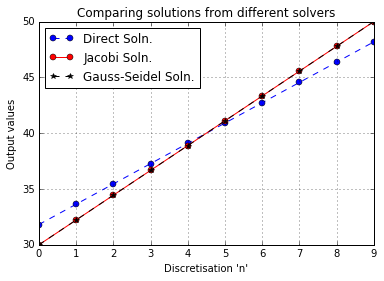

In [16]:
# YOUR CODE HERE
n = 10
dx = n
b0 = 30.
b1 = 50.
max_iter = 10000
epsilon_tol = 1e-6

#Direct Solution
direct = plt.plot(inv_tridiag_121_b(n,b0,b1),'bo--', label='Direct Soln.')
#plt.xlim([-1,10])

#Jacobi Method
u_jac,iter_jac = solve_laplace_jac(b0,b1,dx,max_iter,epsilon_tol)
jacobi = plt.plot(u_jac,'ro-', label='Jacobi Soln.')


#Gauss-Seidel
u_gs,iter_gs = solve_laplace_gs(b0,b1,dx,max_iter,epsilon_tol)
gauss_seidel = plt.plot(u_jac,'k*--', label='Gauss-Seidel Soln.')

plt.title('Comparing solutions from different solvers')
plt.legend(loc = 'upper left')
plt.xlabel("Discretisation 'n'")
plt.ylabel("Output values")
plt.grid()

Print in the following code cell the number of iterations required for conergence by the two solvers

In [17]:
# YOUR CODE HERE
print('The number of iteration required for convergence (Jacobi): %d'%iter_jac)
print('The number of iteration required for convergence (Gauss-Seidel): %d' %iter_gs)

The number of iteration required for convergence (Jacobi): 253
The number of iteration required for convergence (Gauss-Seidel): 134


Describe and interpret the results, and explain why Gauss-Seidel converges with less iterations.

Despite having produced the same results (as seen in the graph above), the solutions reach convergence almost half the time quicker with Gauss-Seidel method (134 iterations) than with Jacobi method (253 iterations). 

The difference between the Jacobi and Gauss-Seidel rule appears in the moment of updating. The calculation of a new nodal value depends on the values of the surrounding nodes.

Jacobi method uses the value of the previous iteration cycle, whereas Gauss-Seidel mehtos uses the newly found value. 

Thus, in Jacobi iteration, the updating occurs when all nodes have been recalculated (have to store a whole set of values/data), while in Gauss-Seidel iteration each node is updated directly when its new value is found (only storing a few relevant value in the process). Therefore, Gausess-Seidel method converges with a lot less iterations compared to Jacobi method.